In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device_lib.list_local_devices() )
PATH = '/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14945697952383815804
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7569436625253731240
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
### 전처리
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(folder_path, target_frame_count=90, image_size=(128, 128), test_size=0.2, random_seed=42):
    labels = []
    data = []

    for label, subfolder in enumerate(os.listdir(folder_path)): # data 폴더 확인
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):     # 하위 폴데 내용 확인
                if filename.endswith(".avi"):       #.avi로 끝나는 파일
                    video_path = os.path.join(subfolder_path, filename)
                    cap = cv2.VideoCapture(video_path)
                    frames = []

                    while cap.isOpened() and len(frames) < target_frame_count:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        resized_frame = cv2.resize(frame, image_size)
                        frames.append(resized_frame)

                    # 프레임 수가 부족하면 패딩을 추가
                    while len(frames) < target_frame_count:
                        frames.append(np.zeros_like(frames[0]))

                    frames = np.array(frames)
                    # 여기서 frames를 사용하여 모델에 데이터로 사용할 수 있음

                    labels.append(label)
                    data.append(frames)

                    cap.release()

    # 데이터를 4D 텐서로 변환 (샘플 수, 프레임 수, 높이, 너비)
    data = np.array(data)

    # 데이터를 0~1 사이의 값으로 정규화
    data = data.astype('float32') / 255.0

    # 라벨을 원-핫 인코딩으로 변환
    labels = np.array(labels)
    num_classes = len(os.listdir(folder_path))
    labels = np.eye(num_classes)[labels]

    # 데이터를 훈련 세트와 테스트 세트로 분할 (각 라벨별 80:20 비율로 유지)
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=random_seed, stratify=labels)
    # # 데이터를 훈련 세트와 테스트 세트로 분할
    # train_data, test_data, train_labels, test_labels = train_test_split(
    #        data, labels, test_size=test_size, random_state=random_seed)

    print("Train data shape:", train_data.shape)
    print("Train labels shape:", train_labels.shape)
    print("Test data shape:", test_data.shape)
    print("Test labels shape:", test_labels.shape)

    return train_data, test_data, train_labels, test_labels

# 사용
folder_path = f"{PATH}/data"  # AVI 파일이 있는 폴더 경로 입력
train_data, test_data, train_labels, test_labels = load_and_preprocess_data(folder_path)



Train data shape: (56, 90, 128, 128, 3)
Train labels shape: (56, 2)
Test data shape: (15, 90, 128, 128, 3)
Test labels shape: (15, 2)


In [4]:
### 전처리된 파일 재생
# 비디오 재생을 위한 함수 정의
def play_video(frames):
    for frame in frames:
        cv2.imshow("Video", frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):  # 'q' 키를 누르면 종료
            break

    cv2.destroyAllWindows()

# # train_data 중 첫 번째 비디오 재생
# for i in range(len(train_data)):
#     play_video(train_data[i])
# play_video(train_data[0])

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_3d_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # 3D Convolution layers
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model
# 모델 생성
input_shape = train_data.shape[1:]
num_classes = len(os.listdir(folder_path))
model = create_3d_cnn_model(input_shape, num_classes)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_data, train_labels, epochs=3, batch_size=4, validation_split=0.2)

# 모델 평가
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_acc}')

# 모델을 저장할 경로
model_save_path = f'{PATH}/model/test2.h5'

# 모델 저장
model.save(model_save_path)

print(f'Model saved to {model_save_path}')

Epoch 1/3
11/11 [==============================] - 20s 405ms/step - loss: 0.7319 - accuracy: 0.6818 - val_loss: 0.2069 - val_accuracy: 0.9167
Epoch 2/3
11/11 [==============================] - 3s 315ms/step - loss: 0.4042 - accuracy: 0.8864 - val_loss: 0.1487 - val_accuracy: 0.9167
Epoch 3/3
1/1 [==============================] - 2s 2s/step - loss: 1.7042e-04 - accuracy: 1.0000
Test accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/model/test2.h5


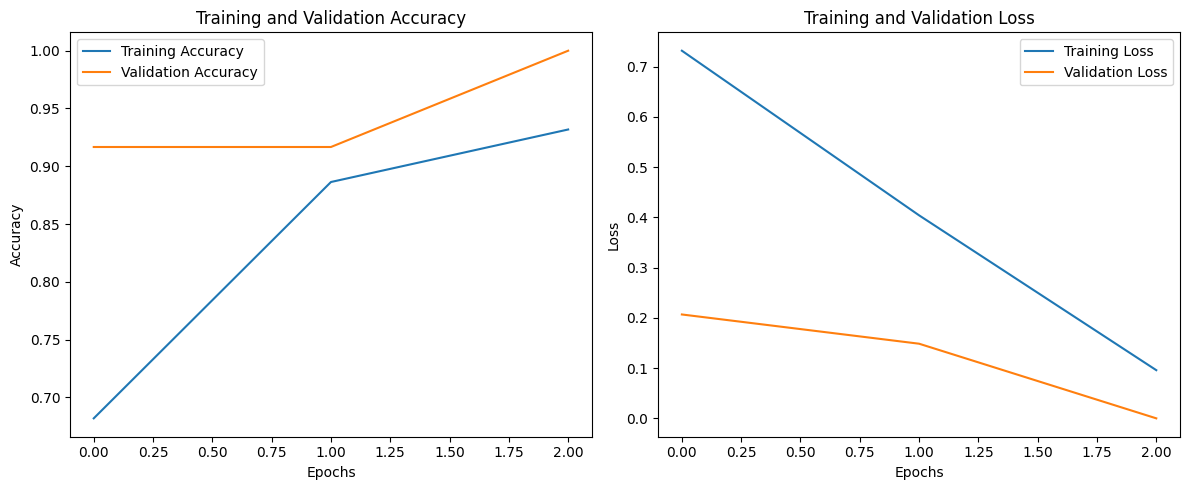

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
